In [69]:

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

#import tensorflow as tf
import os

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [70]:
!pip install tensorflow


# Importing necessary libaries

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Read the data

In [105]:
df=pd.read_csv("MICROSOFT BP DATA.csv")

In [106]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
1,02-04-2014,41.439999,41.660000,41.169998,41.349998,28666700.0,4.0,-0.340000,3665.989990
2,03-04-2014,41.290001,41.290001,40.709999,41.009998,30139600.0,5.0,-1.139999,3637.580078
3,04-04-2014,41.250000,41.389999,39.639999,39.869999,51409600.0,6.0,-0.070000,3539.379883
4,07-04-2014,39.959999,40.270000,39.740002,39.799999,37559600.0,2.0,0.020001,3507.750000


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


# Data Preprocessing

In [108]:
df["Date"] = pd.to_datetime(df["Date"])

In [109]:
df.set_index('Date',inplace=True)

In [110]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
2014-02-04,41.439999,41.660000,41.169998,41.349998,28666700.0,4.0,-0.340000,3665.989990
2014-03-04,41.290001,41.290001,40.709999,41.009998,30139600.0,5.0,-1.139999,3637.580078
2014-04-04,41.250000,41.389999,39.639999,39.869999,51409600.0,6.0,-0.070000,3539.379883
2014-07-04,39.959999,40.270000,39.740002,39.799999,37559600.0,2.0,0.020001,3507.750000


# Missing entries


In [111]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [112]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [113]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [114]:
all_datetimes.shape

(3283,)

# Supplying missing values

## Insert missing datetimes

In [115]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [116]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


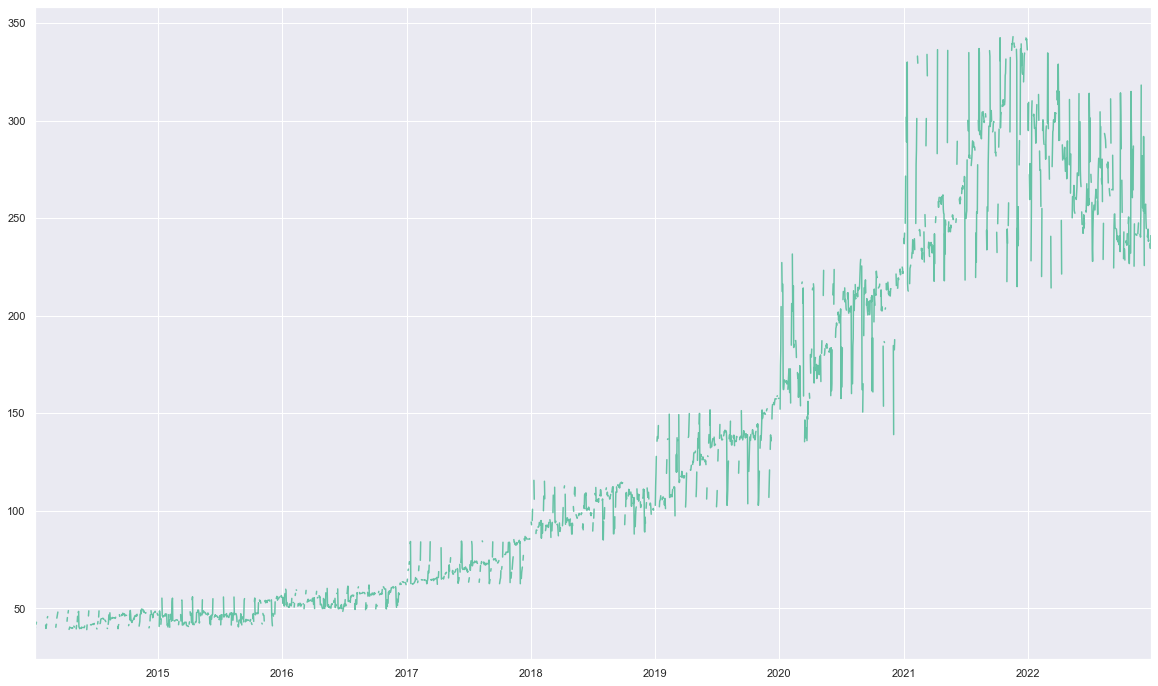

In [117]:
plot = df['Close'].plot(figsize=(20, 12))

In [118]:
df["Close"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df["Open"]=df["Open"].ffill()
df["High"]=df["High"].ffill()
df["Low"]=df["Low"].ffill()
df["Volume"]=df["Volume"].ffill()
df["Change"]=df["Change"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
2014-01-04,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
2014-01-05,40.240002,40.360001,39.950001,40.000000,28787400.0,5.0,-0.310001,3594.360107
2014-01-06,40.240002,40.360001,39.950001,40.000000,28787400.0,NaN,-0.310001,3594.360107
2014-01-07,41.860001,42.150002,41.689999,41.869999,26917000.0,3.0,0.030003,3894.330078
2014-01-08,43.209999,43.250000,42.599998,42.860001,31170300.0,6.0,0.509998,3879.669922
2014-01-09,43.209999,43.250000,42.599998,42.860001,31170300.0,NaN,0.509998,3879.669922
2014-01-10,46.270000,46.529999,45.849998,45.900002,38088400.0,4.0,-0.140004,3984.739990
2014-01-11,46.270000,46.529999,45.849998,45.900002,38088400.0,NaN,-0.140004,3984.739990
2014-01-12,47.880001,48.779999,47.709999,48.619999,31191600.0,2.0,-0.160000,4287.810059
2014-01-13,47.880001,48.779999,47.709999,48.619999,31191600.0,NaN,-0.160000,4287.810059


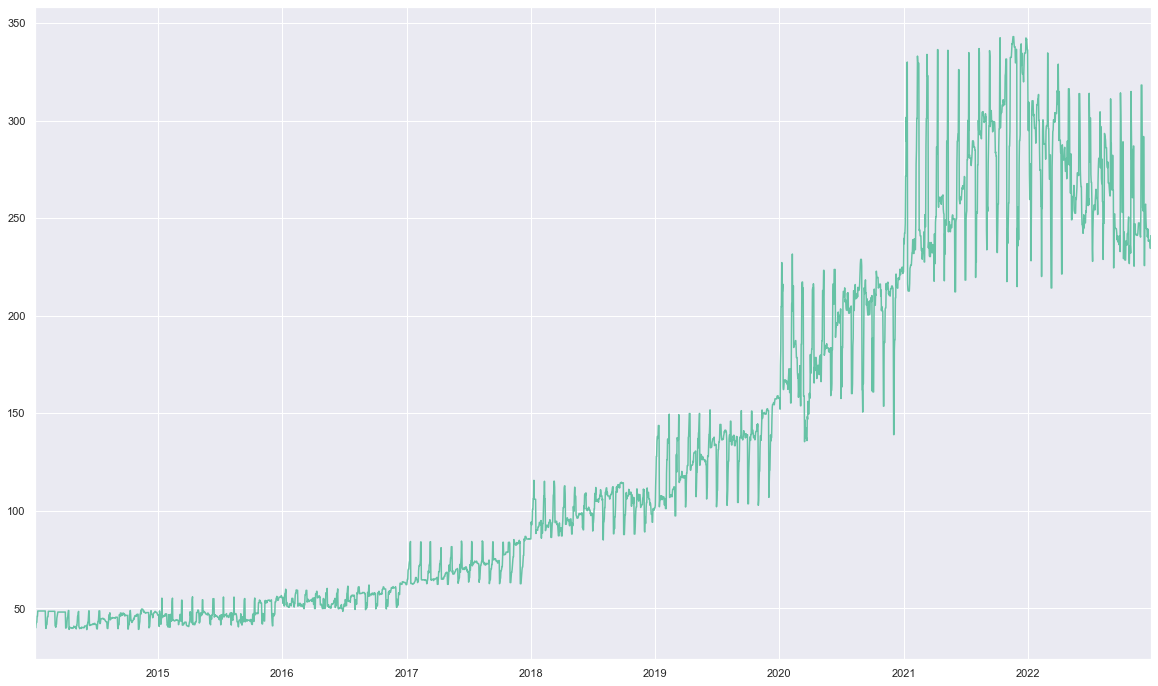

In [119]:
plot = df[ "Close"].plot(figsize=(20, 12))

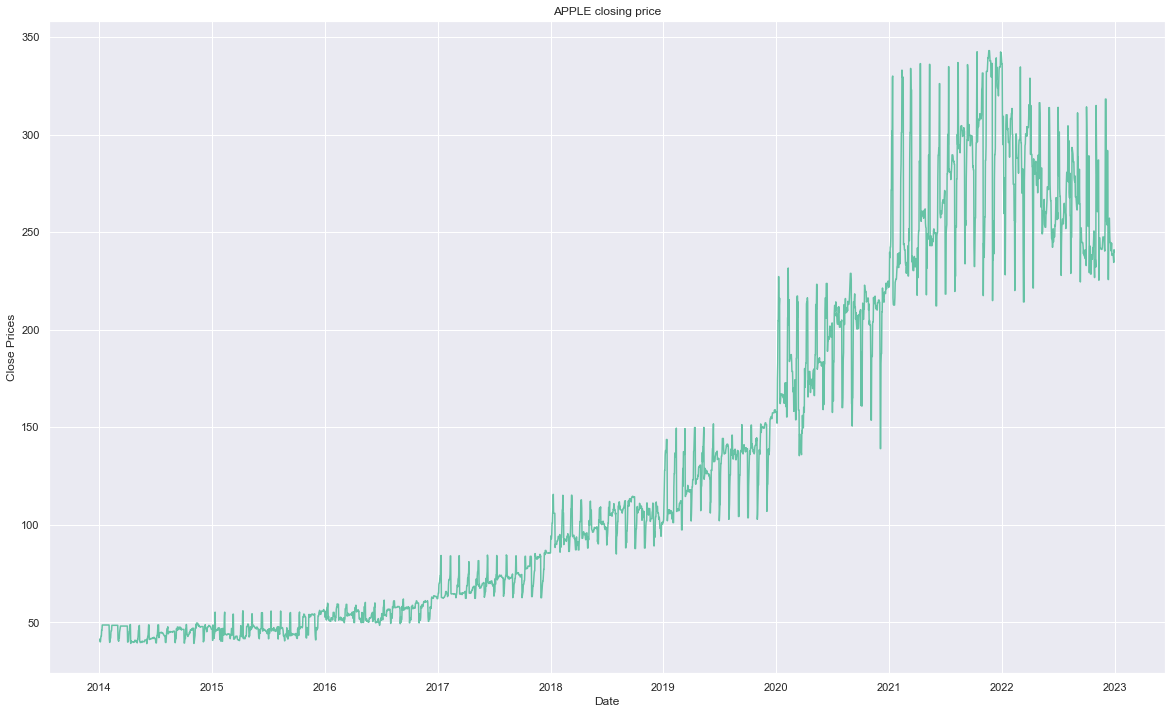

In [120]:
#plot close price
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('APPLE closing price')
plt.show()

In [121]:
df=df["Close"]
df

2014-01-04     41.419998
2014-01-05     40.000000
2014-01-06     40.000000
2014-01-07     41.869999
2014-01-08     42.860001
                 ...    
2022-12-26    238.729996
2022-12-27    236.960007
2022-12-28    234.529999
2022-12-29    241.009995
2022-12-30    239.820007
Name: Close, Length: 3283, dtype: float64

<AxesSubplot:>

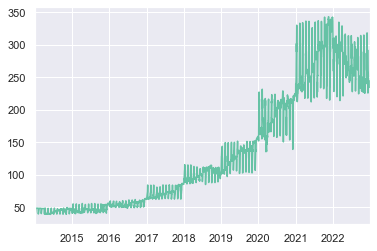

In [122]:
df.plot()

# Build model

In [123]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [124]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((3278, 5, 1), (3278,))

# Train test split

In [125]:
X_train1, y_train1 = X1[:2922], y1[:2922]
X_test1, y_test1 = X1[2922:], y1[2922:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((2922, 5, 1), (2922,), (356, 5, 1), (356,))

In [126]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [129]:
model1.fit(X_train1, y_train1, epochs=100, callbacks=[cp1])

Epoch 1/100
88/92 [===========================>..] - ETA: 0s - loss: 180.2502 - root_mean_squared_error: 13.4257

92/92 [==============================] - 1s 6ms/step - loss: 178.1572 - root_mean_squared_error: 13.3476
Epoch 2/100
90/92 [============================>.] - ETA: 0s - loss: 170.1930 - root_mean_squared_error: 13.0458

92/92 [==============================] - 1s 6ms/step - loss: 169.2421 - root_mean_squared_error: 13.0093
Epoch 3/100
87/92 [===========================>..] - ETA: 0s - loss: 165.1131 - root_mean_squared_error: 12.8496

92/92 [==============================] - 1s 6ms/step - loss: 161.4355 - root_mean_squared_error: 12.7057
Epoch 4/100
91/92 [============================>.] - ETA: 0s - loss: 155.5246 - root_mean_squared_error: 12.4710

92/92 [==============================] - 1s 6ms/step - loss: 155.0209 - root_mean_squared_error: 12.4507
Epoch 5/100
86/92 [===========================>..] - ETA: 0s - loss: 149.0929 - root_mean_squared_error: 12.2104

92/92 [==============================] - 1s 9ms/step - loss: 147.8326 - root_mean_squared_error: 12.1586
Epoch 6/100
88/92 [===========================>..] - ETA: 0s - loss: 140.3630 - root_mean_squared_error: 11.8475

92/92 [==============================] - 1s 7ms/step - loss: 141.8291 - root_mean_squared_error: 11.9092
Epoch 7/100
90/92 [============================>.] - ETA: 0s - loss: 136.6934 - root_mean_squared_error: 11.6916

92/92 [==============================] - 1s 9ms/step - loss: 136.2486 - root_mean_squared_error: 11.6726
Epoch 8/100
89/92 [============================>.] - ETA: 0s - loss: 128.5294 - root_mean_squared_error: 11.3371

92/92 [==============================] - 1s 9ms/step - loss: 131.1007 - root_mean_squared_error: 11.4499
Epoch 9/100
86/92 [===========================>..] - ETA: 0s - loss: 127.2437 - root_mean_squared_error: 11.2802

92/92 [==============================] - 1s 9ms/step - loss: 126.7939 - root_mean_squared_error: 11.2603
Epoch 10/100
87/92 [===========================>..] - ETA: 0s - loss: 120.1851 - root_mean_squared_error: 10.9629

92/92 [==============================] - 1s 9ms/step - loss: 122.4004 - root_mean_squared_error: 11.0635
Epoch 11/100
91/92 [============================>.] - ETA: 0s - loss: 118.1919 - root_mean_squared_error: 10.8716

92/92 [==============================] - 1s 9ms/step - loss: 118.1519 - root_mean_squared_error: 10.8698
Epoch 12/100
90/92 [============================>.] - ETA: 0s - loss: 116.0761 - root_mean_squared_error: 10.7739

92/92 [==============================] - 1s 9ms/step - loss: 114.8240 - root_mean_squared_error: 10.7156
Epoch 13/100
89/92 [============================>.] - ETA: 0s - loss: 111.2147 - root_mean_squared_error: 10.5458

92/92 [==============================] - 1s 8ms/step - loss: 110.7669 - root_mean_squared_error: 10.5246
Epoch 14/100
88/92 [===========================>..] - ETA: 0s - loss: 108.9081 - root_mean_squared_error: 10.4359

92/92 [==============================] - 1s 8ms/step - loss: 107.8276 - root_mean_squared_error: 10.3840
Epoch 15/100
89/92 [============================>.] - ETA: 0s - loss: 106.3265 - root_mean_squared_error: 10.3115

92/92 [==============================] - 1s 8ms/step - loss: 106.1460 - root_mean_squared_error: 10.3027
Epoch 16/100
91/92 [============================>.] - ETA: 0s - loss: 103.2122 - root_mean_squared_error: 10.1593

92/92 [==============================] - 1s 8ms/step - loss: 102.9390 - root_mean_squared_error: 10.1459
Epoch 17/100
87/92 [===========================>..] - ETA: 0s - loss: 101.6976 - root_mean_squared_error: 10.0845

92/92 [==============================] - 1s 8ms/step - loss: 100.8108 - root_mean_squared_error: 10.0405
Epoch 18/100
89/92 [============================>.] - ETA: 0s - loss: 100.6426 - root_mean_squared_error: 10.0321

92/92 [==============================] - 1s 8ms/step - loss: 98.4710 - root_mean_squared_error: 9.9233
Epoch 19/100
88/92 [===========================>..] - ETA: 0s - loss: 96.9904 - root_mean_squared_error: 9.8484

92/92 [==============================] - 1s 9ms/step - loss: 96.4316 - root_mean_squared_error: 9.8200
Epoch 20/100
91/92 [============================>.] - ETA: 0s - loss: 94.0493 - root_mean_squared_error: 9.6979

92/92 [==============================] - 1s 9ms/step - loss: 94.7422 - root_mean_squared_error: 9.7336
Epoch 21/100
87/92 [===========================>..] - ETA: 0s - loss: 95.9753 - root_mean_squared_error: 9.7967  

92/92 [==============================] - 1s 9ms/step - loss: 94.7396 - root_mean_squared_error: 9.7334
Epoch 22/100
88/92 [===========================>..] - ETA: 0s - loss: 93.2061 - root_mean_squared_error: 9.6543

92/92 [==============================] - 1s 8ms/step - loss: 91.9813 - root_mean_squared_error: 9.5907
Epoch 23/100
86/92 [===========================>..] - ETA: 0s - loss: 89.2126 - root_mean_squared_error: 9.4452

92/92 [==============================] - 1s 8ms/step - loss: 90.5317 - root_mean_squared_error: 9.5148
Epoch 24/100
90/92 [============================>.] - ETA: 0s - loss: 89.6704 - root_mean_squared_error: 9.4694

92/92 [==============================] - 1s 9ms/step - loss: 89.4227 - root_mean_squared_error: 9.4564
Epoch 25/100
89/92 [============================>.] - ETA: 0s - loss: 88.4516 - root_mean_squared_error: 9.4049

92/92 [==============================] - 1s 10ms/step - loss: 89.0255 - root_mean_squared_error: 9.4353
Epoch 26/100
92/92 [==============================] - ETA: 0s - loss: 87.6340 - root_mean_squared_error: 9.3613

92/92 [==============================] - 1s 8ms/step - loss: 87.6340 - root_mean_squared_error: 9.3613
Epoch 27/100
91/92 [============================>.] - ETA: 0s - loss: 86.4629 - root_mean_squared_error: 9.2985

92/92 [==============================] - 1s 8ms/step - loss: 86.8650 - root_mean_squared_error: 9.3201
Epoch 28/100
90/92 [============================>.] - ETA: 0s - loss: 86.5112 - root_mean_squared_error: 9.3011

92/92 [==============================] - 1s 9ms/step - loss: 87.0031 - root_mean_squared_error: 9.3275
Epoch 29/100
89/92 [============================>.] - ETA: 0s - loss: 85.7822 - root_mean_squared_error: 9.2619

92/92 [==============================] - 1s 9ms/step - loss: 85.0828 - root_mean_squared_error: 9.2240
Epoch 30/100
90/92 [============================>.] - ETA: 0s - loss: 84.5966 - root_mean_squared_error: 9.1976

92/92 [==============================] - 1s 9ms/step - loss: 84.9710 - root_mean_squared_error: 9.2180
Epoch 31/100
87/92 [===========================>..] - ETA: 0s - loss: 86.3774 - root_mean_squared_error: 9.2939

92/92 [==============================] - 1s 8ms/step - loss: 85.1797 - root_mean_squared_error: 9.2293
Epoch 32/100
89/92 [============================>.] - ETA: 0s - loss: 83.4124 - root_mean_squared_error: 9.1330

92/92 [==============================] - 1s 10ms/step - loss: 83.4306 - root_mean_squared_error: 9.1340
Epoch 33/100
89/92 [============================>.] - ETA: 0s - loss: 84.7827 - root_mean_squared_error: 9.2078

92/92 [==============================] - 1s 8ms/step - loss: 83.4131 - root_mean_squared_error: 9.1331
Epoch 34/100
89/92 [============================>.] - ETA: 0s - loss: 79.9884 - root_mean_squared_error: 8.9436

92/92 [==============================] - 1s 8ms/step - loss: 82.6644 - root_mean_squared_error: 9.0920
Epoch 35/100
89/92 [============================>.] - ETA: 0s - loss: 83.2436 - root_mean_squared_error: 9.1238

92/92 [==============================] - 1s 9ms/step - loss: 82.9114 - root_mean_squared_error: 9.1056
Epoch 36/100
90/92 [============================>.] - ETA: 0s - loss: 84.4218 - root_mean_squared_error: 9.1881

92/92 [==============================] - 1s 8ms/step - loss: 83.4686 - root_mean_squared_error: 9.1361
Epoch 37/100
91/92 [============================>.] - ETA: 0s - loss: 82.2399 - root_mean_squared_error: 9.0686

92/92 [==============================] - 1s 9ms/step - loss: 82.3693 - root_mean_squared_error: 9.0758
Epoch 38/100
90/92 [============================>.] - ETA: 0s - loss: 79.0199 - root_mean_squared_error: 8.8893

92/92 [==============================] - 1s 9ms/step - loss: 81.4021 - root_mean_squared_error: 9.0223
Epoch 39/100
90/92 [============================>.] - ETA: 0s - loss: 82.3037 - root_mean_squared_error: 9.0721

92/92 [==============================] - 1s 9ms/step - loss: 81.4289 - root_mean_squared_error: 9.0238
Epoch 40/100
90/92 [============================>.] - ETA: 0s - loss: 81.6106 - root_mean_squared_error: 9.0339

92/92 [==============================] - 1s 8ms/step - loss: 80.8632 - root_mean_squared_error: 8.9924
Epoch 41/100
89/92 [============================>.] - ETA: 0s - loss: 80.2745 - root_mean_squared_error: 8.9596

92/92 [==============================] - 1s 8ms/step - loss: 81.3264 - root_mean_squared_error: 9.0181
Epoch 42/100
90/92 [============================>.] - ETA: 0s - loss: 81.7827 - root_mean_squared_error: 9.0434

92/92 [==============================] - 1s 9ms/step - loss: 80.8222 - root_mean_squared_error: 8.9901
Epoch 43/100
91/92 [============================>.] - ETA: 0s - loss: 80.6451 - root_mean_squared_error: 8.9803

92/92 [==============================] - 1s 9ms/step - loss: 80.4969 - root_mean_squared_error: 8.9720
Epoch 44/100
88/92 [===========================>..] - ETA: 0s - loss: 81.1489 - root_mean_squared_error: 9.0083

92/92 [==============================] - 1s 9ms/step - loss: 79.9231 - root_mean_squared_error: 8.9400
Epoch 45/100
92/92 [==============================] - ETA: 0s - loss: 80.3498 - root_mean_squared_error: 8.9638

92/92 [==============================] - 1s 9ms/step - loss: 80.3498 - root_mean_squared_error: 8.9638
Epoch 46/100
87/92 [===========================>..] - ETA: 0s - loss: 80.3825 - root_mean_squared_error: 8.9656

92/92 [==============================] - 1s 8ms/step - loss: 79.5904 - root_mean_squared_error: 8.9213
Epoch 47/100
92/92 [==============================] - ETA: 0s - loss: 79.5727 - root_mean_squared_error: 8.9204

92/92 [==============================] - 1s 8ms/step - loss: 79.5727 - root_mean_squared_error: 8.9204
Epoch 48/100
90/92 [============================>.] - ETA: 0s - loss: 80.5938 - root_mean_squared_error: 8.9774

92/92 [==============================] - 1s 9ms/step - loss: 79.8466 - root_mean_squared_error: 8.9357
Epoch 49/100
89/92 [============================>.] - ETA: 0s - loss: 80.0490 - root_mean_squared_error: 8.9470

92/92 [==============================] - 1s 9ms/step - loss: 79.8515 - root_mean_squared_error: 8.9360
Epoch 50/100
87/92 [===========================>..] - ETA: 0s - loss: 81.2725 - root_mean_squared_error: 9.0151

92/92 [==============================] - 1s 9ms/step - loss: 79.7533 - root_mean_squared_error: 8.9305
Epoch 51/100
91/92 [============================>.] - ETA: 0s - loss: 79.6948 - root_mean_squared_error: 8.9272

92/92 [==============================] - 1s 9ms/step - loss: 79.4306 - root_mean_squared_error: 8.9124
Epoch 52/100
90/92 [============================>.] - ETA: 0s - loss: 80.0853 - root_mean_squared_error: 8.9490

92/92 [==============================] - 1s 9ms/step - loss: 79.3830 - root_mean_squared_error: 8.9097
Epoch 53/100
87/92 [===========================>..] - ETA: 0s - loss: 81.5348 - root_mean_squared_error: 9.0297

92/92 [==============================] - 1s 8ms/step - loss: 79.6250 - root_mean_squared_error: 8.9233
Epoch 54/100
91/92 [============================>.] - ETA: 0s - loss: 79.6609 - root_mean_squared_error: 8.9253

92/92 [==============================] - 1s 7ms/step - loss: 79.4046 - root_mean_squared_error: 8.9109
Epoch 55/100
90/92 [============================>.] - ETA: 0s - loss: 79.6115 - root_mean_squared_error: 8.9225

92/92 [==============================] - 1s 9ms/step - loss: 78.9228 - root_mean_squared_error: 8.8839
Epoch 56/100
92/92 [==============================] - ETA: 0s - loss: 79.0605 - root_mean_squared_error: 8.8916

92/92 [==============================] - 1s 9ms/step - loss: 79.0605 - root_mean_squared_error: 8.8916
Epoch 57/100
91/92 [============================>.] - ETA: 0s - loss: 78.4253 - root_mean_squared_error: 8.8558

92/92 [==============================] - 1s 9ms/step - loss: 78.4124 - root_mean_squared_error: 8.8551
Epoch 58/100
84/92 [==========================>...] - ETA: 0s - loss: 78.5218 - root_mean_squared_error: 8.8613

92/92 [==============================] - 1s 8ms/step - loss: 78.3249 - root_mean_squared_error: 8.8501
Epoch 59/100
87/92 [===========================>..] - ETA: 0s - loss: 75.8375 - root_mean_squared_error: 8.7085

92/92 [==============================] - 1s 9ms/step - loss: 79.1318 - root_mean_squared_error: 8.8956
Epoch 60/100
92/92 [==============================] - ETA: 0s - loss: 78.6171 - root_mean_squared_error: 8.8666

92/92 [==============================] - 1s 9ms/step - loss: 78.6171 - root_mean_squared_error: 8.8666
Epoch 61/100
91/92 [============================>.] - ETA: 0s - loss: 78.3708 - root_mean_squared_error: 8.8527

92/92 [==============================] - 1s 9ms/step - loss: 78.6034 - root_mean_squared_error: 8.8659
Epoch 62/100
90/92 [============================>.] - ETA: 0s - loss: 78.6639 - root_mean_squared_error: 8.8693

92/92 [==============================] - 1s 9ms/step - loss: 78.1519 - root_mean_squared_error: 8.8404
Epoch 63/100
92/92 [==============================] - ETA: 0s - loss: 78.2128 - root_mean_squared_error: 8.8438

92/92 [==============================] - 1s 8ms/step - loss: 78.2128 - root_mean_squared_error: 8.8438
Epoch 64/100
87/92 [===========================>..] - ETA: 0s - loss: 77.0970 - root_mean_squared_error: 8.7805

92/92 [==============================] - 1s 7ms/step - loss: 78.5872 - root_mean_squared_error: 8.8649
Epoch 65/100
87/92 [===========================>..] - ETA: 0s - loss: 79.4403 - root_mean_squared_error: 8.9129

92/92 [==============================] - 1s 8ms/step - loss: 79.1547 - root_mean_squared_error: 8.8969
Epoch 66/100
92/92 [==============================] - ETA: 0s - loss: 78.9739 - root_mean_squared_error: 8.8867

92/92 [==============================] - 1s 8ms/step - loss: 78.9739 - root_mean_squared_error: 8.8867
Epoch 67/100
90/92 [============================>.] - ETA: 0s - loss: 78.0673 - root_mean_squared_error: 8.8356

92/92 [==============================] - 1s 9ms/step - loss: 78.5657 - root_mean_squared_error: 8.8637
Epoch 68/100
89/92 [============================>.] - ETA: 0s - loss: 77.7036 - root_mean_squared_error: 8.8150

92/92 [==============================] - 1s 9ms/step - loss: 77.8113 - root_mean_squared_error: 8.8211
Epoch 69/100
89/92 [============================>.] - ETA: 0s - loss: 79.1293 - root_mean_squared_error: 8.8955

92/92 [==============================] - 1s 9ms/step - loss: 78.4578 - root_mean_squared_error: 8.8576
Epoch 70/100
92/92 [==============================] - ETA: 0s - loss: 78.4460 - root_mean_squared_error: 8.8570

92/92 [==============================] - 1s 9ms/step - loss: 78.4460 - root_mean_squared_error: 8.8570
Epoch 71/100
88/92 [===========================>..] - ETA: 0s - loss: 76.3027 - root_mean_squared_error: 8.7351

92/92 [==============================] - 1s 8ms/step - loss: 77.9663 - root_mean_squared_error: 8.8299
Epoch 72/100
90/92 [============================>.] - ETA: 0s - loss: 79.0082 - root_mean_squared_error: 8.8887

92/92 [==============================] - 1s 9ms/step - loss: 78.1958 - root_mean_squared_error: 8.8428
Epoch 73/100
91/92 [============================>.] - ETA: 0s - loss: 77.9847 - root_mean_squared_error: 8.8309

92/92 [==============================] - 1s 9ms/step - loss: 77.7545 - root_mean_squared_error: 8.8179
Epoch 74/100
88/92 [===========================>..] - ETA: 0s - loss: 78.6620 - root_mean_squared_error: 8.8692

92/92 [==============================] - 1s 8ms/step - loss: 78.3426 - root_mean_squared_error: 8.8511
Epoch 75/100
90/92 [============================>.] - ETA: 0s - loss: 78.1318 - root_mean_squared_error: 8.8392

92/92 [==============================] - 1s 8ms/step - loss: 78.0368 - root_mean_squared_error: 8.8338
Epoch 76/100
87/92 [===========================>..] - ETA: 0s - loss: 78.0676 - root_mean_squared_error: 8.8356

92/92 [==============================] - 1s 9ms/step - loss: 78.5933 - root_mean_squared_error: 8.8653
Epoch 77/100
90/92 [============================>.] - ETA: 0s - loss: 77.9409 - root_mean_squared_error: 8.8284

92/92 [==============================] - 1s 9ms/step - loss: 78.0773 - root_mean_squared_error: 8.8361
Epoch 78/100
88/92 [===========================>..] - ETA: 0s - loss: 76.9157 - root_mean_squared_error: 8.7702

92/92 [==============================] - 1s 8ms/step - loss: 78.5133 - root_mean_squared_error: 8.8608
Epoch 79/100
91/92 [============================>.] - ETA: 0s - loss: 78.0944 - root_mean_squared_error: 8.8371

92/92 [==============================] - 1s 9ms/step - loss: 77.8833 - root_mean_squared_error: 8.8251
Epoch 80/100
90/92 [============================>.] - ETA: 0s - loss: 78.4391 - root_mean_squared_error: 8.8566

92/92 [==============================] - 1s 9ms/step - loss: 77.7386 - root_mean_squared_error: 8.8170
Epoch 81/100
92/92 [==============================] - ETA: 0s - loss: 78.0204 - root_mean_squared_error: 8.8329

92/92 [==============================] - 1s 11ms/step - loss: 78.0204 - root_mean_squared_error: 8.8329
Epoch 82/100
88/92 [===========================>..] - ETA: 0s - loss: 78.7865 - root_mean_squared_error: 8.8762

92/92 [==============================] - 1s 10ms/step - loss: 78.4897 - root_mean_squared_error: 8.8594
Epoch 83/100
88/92 [===========================>..] - ETA: 0s - loss: 79.6048 - root_mean_squared_error: 8.9222

92/92 [==============================] - 1s 11ms/step - loss: 78.1032 - root_mean_squared_error: 8.8376
Epoch 84/100
90/92 [============================>.] - ETA: 0s - loss: 78.7145 - root_mean_squared_error: 8.8721

92/92 [==============================] - 1s 9ms/step - loss: 78.1569 - root_mean_squared_error: 8.8406
Epoch 85/100
87/92 [===========================>..] - ETA: 0s - loss: 77.3833 - root_mean_squared_error: 8.7968

92/92 [==============================] - 1s 9ms/step - loss: 77.9383 - root_mean_squared_error: 8.8283
Epoch 86/100
91/92 [============================>.] - ETA: 0s - loss: 78.1516 - root_mean_squared_error: 8.8403

92/92 [==============================] - 1s 9ms/step - loss: 78.3680 - root_mean_squared_error: 8.8526
Epoch 87/100
86/92 [===========================>..] - ETA: 0s - loss: 74.7956 - root_mean_squared_error: 8.6484

92/92 [==============================] - 1s 8ms/step - loss: 77.8027 - root_mean_squared_error: 8.8206
Epoch 88/100
87/92 [===========================>..] - ETA: 0s - loss: 78.8203 - root_mean_squared_error: 8.8781

92/92 [==============================] - 1s 7ms/step - loss: 77.8735 - root_mean_squared_error: 8.8246
Epoch 89/100
89/92 [============================>.] - ETA: 0s - loss: 79.3144 - root_mean_squared_error: 8.9059

92/92 [==============================] - 1s 9ms/step - loss: 78.4695 - root_mean_squared_error: 8.8583
Epoch 90/100
92/92 [==============================] - ETA: 0s - loss: 77.9761 - root_mean_squared_error: 8.8304

92/92 [==============================] - 1s 9ms/step - loss: 77.9761 - root_mean_squared_error: 8.8304
Epoch 91/100
89/92 [============================>.] - ETA: 0s - loss: 79.1818 - root_mean_squared_error: 8.8984

92/92 [==============================] - 1s 8ms/step - loss: 78.1728 - root_mean_squared_error: 8.8415
Epoch 92/100
89/92 [============================>.] - ETA: 0s - loss: 77.2428 - root_mean_squared_error: 8.7888

92/92 [==============================] - 1s 7ms/step - loss: 78.1611 - root_mean_squared_error: 8.8409
Epoch 93/100
90/92 [============================>.] - ETA: 0s - loss: 78.0465 - root_mean_squared_error: 8.8344

92/92 [==============================] - 1s 10ms/step - loss: 78.0718 - root_mean_squared_error: 8.8358
Epoch 94/100
90/92 [============================>.] - ETA: 0s - loss: 74.4615 - root_mean_squared_error: 8.6291

92/92 [==============================] - 1s 8ms/step - loss: 77.8896 - root_mean_squared_error: 8.8255
Epoch 95/100
90/92 [============================>.] - ETA: 0s - loss: 78.3392 - root_mean_squared_error: 8.8509

92/92 [==============================] - 1s 9ms/step - loss: 78.3752 - root_mean_squared_error: 8.8530
Epoch 96/100
89/92 [============================>.] - ETA: 0s - loss: 79.3089 - root_mean_squared_error: 8.9056

92/92 [==============================] - 1s 9ms/step - loss: 78.3118 - root_mean_squared_error: 8.8494
Epoch 97/100
88/92 [===========================>..] - ETA: 0s - loss: 76.4989 - root_mean_squared_error: 8.7464

92/92 [==============================] - 1s 9ms/step - loss: 77.8882 - root_mean_squared_error: 8.8254
Epoch 98/100
88/92 [===========================>..] - ETA: 0s - loss: 76.9329 - root_mean_squared_error: 8.7711

92/92 [==============================] - 1s 9ms/step - loss: 77.6338 - root_mean_squared_error: 8.8110
Epoch 99/100
88/92 [===========================>..] - ETA: 0s - loss: 79.8035 - root_mean_squared_error: 8.9333

92/92 [==============================] - 1s 12ms/step - loss: 77.8683 - root_mean_squared_error: 8.8243
Epoch 100/100
88/92 [===========================>..] - ETA: 0s - loss: 78.9122 - root_mean_squared_error: 8.8833

92/92 [==============================] - 1s 10ms/step - loss: 77.2845 - root_mean_squared_error: 8.7912


In [130]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

92/92 [==============================] - 1s 5ms/step


,Train Predictions,Actuals
0,42.975460,42.860001
1,42.849964,45.900002
2,45.529125,45.900002
3,45.404743,48.619999
4,47.888966,48.619999
...,...,...
2917,299.671234,309.420013
2918,309.307495,309.420013
2919,309.777008,272.420013
2920,275.797058,259.579987


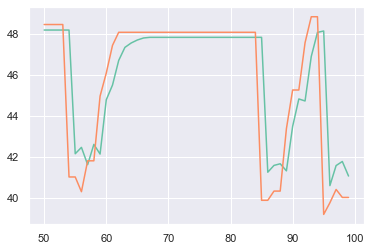

In [131]:

plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [132]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

12/12 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,280.336121,260.399994
1,267.107788,260.399994
2,262.028473,228.169998
3,235.033478,254.690002
4,250.598480,304.799988
...,...,...
351,241.507294,238.729996
352,241.493683,236.960007
353,239.809540,234.529999
354,236.881104,241.009995


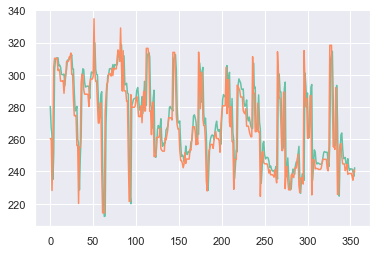

In [133]:
plt.plot(test_results['Test Predictions'][:356])
plt.plot(test_results['Actuals'][:356])

# Evaluating forecast results

In [134]:
score = np.sqrt(mean_squared_error(test_results['Test Predictions'], test_results['Actuals']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 16.69


In [135]:
# report performance
mse = mean_squared_error(test_predictions, y_test1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_predictions, y_test1)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_predictions, y_test1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_test1 - test_predictions)/np.abs(test_predictions))
print('MAPE: '+str(mape))

MSE: 278.4970885387904
MAE: 10.398200778981412
RMSE: 16.68823203754042
MAPE: 0.038701682938195155


In [137]:
get_mda(y_test1,test_predictions)

0.352112676056338